In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from scipy.stats import trim_mean
from sklearn.metrics import mean_squared_error
import collections

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference import settings
from higgs_inference.various.utils import format_number


# Settings

In [26]:
colors     = ['orange', 'darkgreen',  'c', 'mediumblue', 'mediumblue', '#be96ff', '#CC002E', 'c', '#CC002E']
linestyles = [     ':',        '--',  ':',         '-.',      ':',   '-.',      '--', '-',    '-']
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]
markers    = [None] + ['o'] * 8

In [21]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.12
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

# Data

In [22]:
result_dir = '../results/'

def expected_mse_log_r(filename, folder='parameterized'):
    mse_log_r = np.load(result_dir + folder + '/mse_logr_' + filename + '.npy')
    return np.sum(settings.theta_prior * mse_log_r)
                       
def expected_trimmed_mse_log_r(filename, folder='parameterized'):
    mse_log_r = np.load(result_dir + folder + '/trimmed_mse_logr_' + filename + '.npy')
    return np.sum(settings.theta_prior * mse_log_r)


In [23]:
def load_data(filename_reduced, filename_full, folder,
              sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000,
                              1000000, 2000000, 5000000],
              sample_size_full = 10000000):
    
    results_metrics = []
    results_trimmed_metrics = []
    results_samplesize = []
    
    print('')
    print('Strategy', filename_full)
    
    if filename_reduced is None:
        results_metrics.append(expected_mse_log_r(filename_full, folder))
        results_metrics.append(expected_mse_log_r(filename_full, folder))
        results_trimmed_metrics.append(expected_trimmed_mse_log_r(filename_full, folder))
        results_trimmed_metrics.append(expected_trimmed_mse_log_r(filename_full, folder))
        results_samplesize.append(0.)
        results_samplesize.append(1.e9)
        
        return results_samplesize, results_metrics, results_trimmed_metrics
        
    for ss in sample_sizes:
        try:
            this_filename = filename_reduced.replace('%s', str(ss))
            results_metrics.append(expected_mse_log_r(this_filename, folder))
            results_trimmed_metrics.append(expected_trimmed_mse_log_r(this_filename, folder))
            results_samplesize.append(ss)
            print(' ', ss, results_metrics[-1])
        except IOError:
            pass
        
    try:
        results_metrics.append(expected_mse_log_r(filename_full, folder))
        results_trimmed_metrics.append(expected_trimmed_mse_log_r(filename_full, folder))
        results_samplesize.append(sample_size_full)
        print(' ', 'full', results_metrics[-1])
    except IOError:
        pass
    
    return results_samplesize, results_metrics, results_trimmed_metrics


In [24]:
mse = []
trimmed_mse = []
sample_sizes = []

labels = ['2D histogram',
          'CARL',
          'ROLR',
          'SALLY',
          'SALLINO',
          'CASCAL',
          'RASCAL',
          'ROLR X',
          'RASCAL X']

filenames_full = ['histo_2d_asymmetricbinning',
                  'carl_calibrated_shallow',
                  'regression_calibrated',
                  'scoreregression_rotatedscore_deep',
                  'scoreregression_scoretheta_deep',
                  'combined_calibrated_deep',
                  'combinedregression_calibrated_deep',
                  'mxe_calibrated_deep',
                  'combinedmxe_calibrated_deep']
filenames = [None,
             'carl_calibrated_shallow_trainingsamplesize_%s',
             'regression_calibrated_trainingsamplesize_%s',
             'scoreregression_rotatedscore_deep_trainingsamplesize_%s',
             'scoreregression_scoretheta_deep_trainingsamplesize_%s',
             'combined_calibrated_deep_trainingsamplesize_%s',
             'combinedregression_calibrated_deep_trainingsamplesize_%s',
             'mxe_calibrated_deep_trainingsamplesize_%s',
             'combinedmxe_calibrated_deep_trainingsamplesize_%s']
folders = ['histo',
           'parameterized',
           'parameterized', 
           'score_regression',
           'score_regression',
           'parameterized', 
           'parameterized',
           'parameterized', 
           'parameterized']

for filename, filename_full, folder in zip(filenames, filenames_full, folders):
    _sample_sizes, _mse, _trimmed_mse = load_data(filename, filename_full, folder)
    sample_sizes.append(_sample_sizes)
    trimmed_mse.append(_trimmed_mse)
    mse.append(_mse)
    
n_strategies = len(labels)
    


Strategy histo_2d_asymmetricbinning

Strategy carl_calibrated_shallow
  1000 0.1756124625047869
  2000 0.1772929090058638
  5000 0.17560112398265795
  10000 0.17430976940373513
  100000 0.16806492990830596
  200000 0.14836464935940705
  500000 0.09598188256014215
  1000000 0.06587248745031965
  2000000 0.03919518592169335
  5000000 0.020387260928715283
  full 0.012361560372979625

Strategy regression_calibrated
  1000 0.1671312085918133
  2000 0.16254916677739084
  5000 0.14883948562615434
  10000 0.13448500894416354
  20000 0.10259735273499933
  50000 0.05459030295696865
  100000 0.03895275270211597
  200000 0.031682078012704236
  500000 0.017369364490463536
  1000000 0.013091191299489203
  2000000 0.005923698170810491
  5000000 0.0034942463984002506
  full 0.003184787641439353

Strategy scoreregression_rotatedscore_deep
  1000 0.06837321745599728
  2000 0.051417385323589866
  5000 0.0356409358073896
  10000 0.026105706305073882
  20000 0.020323339014909902
  50000 0.0161641537208229

# Plot

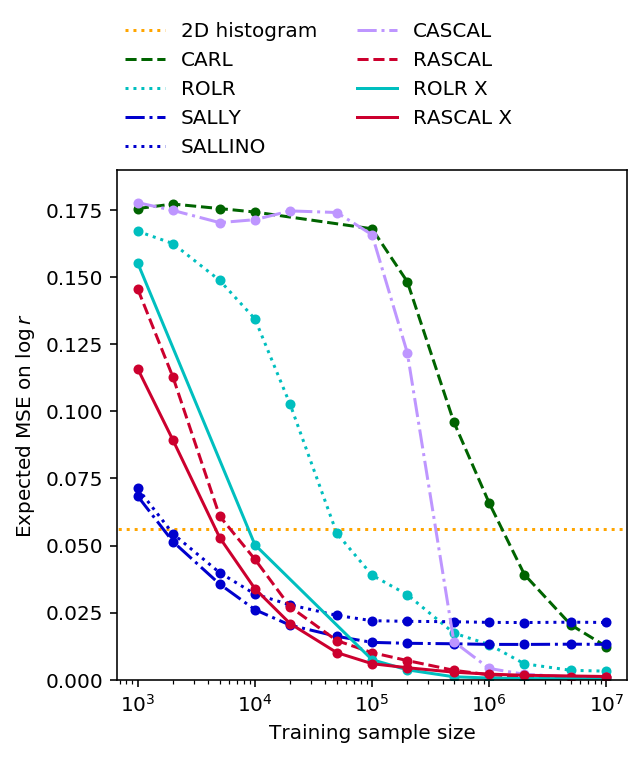

In [27]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,extra_top_space=True)))
ax = plt.gca()

for s in range(n_strategies):
    plt.plot(sample_sizes[s], mse[s],
             ms=4., marker=markers[s],
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s])
    plt.plot([], [],
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s],
             label=labels[s])

plt.legend(loc='lower left', bbox_to_anchor=(-0.02,.99), frameon=False, ncol=2)

ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.xlim(1.e3/1.5, 1.5e7)
plt.ylim(-0.00, 0.19)
plt.xlabel(r"Training sample size")
plt.ylabel(r"Expected MSE on $\log \, r$")

adjust_margins(1,4.5,extra_top_space=True)
plt.savefig("../figures/sample_size_followup.pdf")
